In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.callbacks import EarlyStopping

import os
import cv2

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/food/food0117.zip",  "r") as target_file:
  target_file.extractall("/content/drive/MyDrive/food/food0117/")

In [6]:
# DATA ROOT DIR 설정
DATA_ROOT_DIR = os.path.join('/content/drive/MyDrive/food/food0117') 
label_name_list = os.listdir(DATA_ROOT_DIR)

In [7]:
import glob
import cv2

image_list=[]
label_list=[]

# 경로 지정
for label_name in label_name_list:
    file_path = os.path.join(DATA_ROOT_DIR, label_name)
    img_file_list=glob.glob(file_path + "/*.*")
    
    # 폴더 별로 반복문 돌리기
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
        src_img = cv2.resize(src_img, dsize=(128,128)) # 사이즈 조절
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환
        
        image_list.append(src_img) # X값
        label_list.append(float(label_name)) # Y값

In [8]:
# list에 담겼는지 확인
print(len(image_list),len(label_list))

16344 16344


In [9]:
# 10563 10563 폴더 0,1,2,3,4

In [11]:
X_train, X_test, y_train, y_test =train_test_split(np.array(image_list),
                                                   np.array(label_list),
                                                   test_size=0.2,
                                                   stratify=np.array(label_list)) # label을 비율에 맞게 설정

In [12]:
# shape확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13075, 128, 128, 3) (3269, 128, 128, 3) (13075,) (3269,)


In [13]:
# 정규화
X_train= X_train.astype(np.float32) /255.0
X_test= X_test.astype(np.float32) /255.0

In [14]:
tr_gen=ImageDataGenerator(rotation_range=10,
                           width_shift_range=0.3,
                           height_shift_range=0.3,
                           zoom_range= 0.1)

idg_tr= tr_gen.flow(X_train, y_train, batch_size=128, shuffle=True)

In [ ]:
# 모델 설계

model = Sequential()


model.add(Conv2D(input_shape=(128,128,3), kernel_size=3,
                 filters=32,strides=(1,1), padding="SAME", activation="relu"))

# 1sf conv layer
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=3,filters=64,
                 strides=(1,1), padding="SAME", activation="relu"))

model.add(Dropout(0.5))

# 2nd conv layer
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=3,filters=128,
                 strides=(1,1), padding="SAME", activation="relu",kernel_initializer="he_normal"))

# 3rd conv layer
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=3,filters=256,
                 strides=(1,1), padding="SAME", activation="relu"))


model.add(Dropout(0.5))

model.add(Flatten())


model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

# 출력층
model.add(Dense(5, activation="softmax"))



model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])




In [ ]:
# 모델 summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout_11 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)      

In [ ]:
# 시간 측정
from datetime import datetime

earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

start_time = datetime.now()
result= model.fit(idg_tr, epochs=300, validation_data=(X_test,y_test),batch_size=64, callbacks=[earlystopping])
end_time = datetime.now()

print("\n걸린 시간 : ",end_time - start_time)

Epoch 1/300
103/103 [==============================] - 47s 450ms/step - loss: nan - accuracy: 0.2449 - val_loss: nan - val_accuracy: 0.2459
Epoch 2/300
 33/103 [========>.....................] - ETA: 30s - loss: nan - accuracy: 0.2552

KeyboardInterrupt: ignored

In [ ]:
# evaluate
model.evaluate(X_test, y_test)

67/67 [==============================] - 0s 5ms/step - loss: 0.2738 - accuracy: 0.9068


[0.2737515866756439, 0.9067676067352295]

In [ ]:
# 1st record val_loss: 1.3691 - val_accuracy: 0.7468, evaluation : 측정 불가
# 2st record val_loss: 1.2780 - val_accuracy: 0.7556  size =(64,64), evaluation : loss: 1.3522 - accuracy: 0.7487 / size=(64,64)로 수정

# 3rd evaluation : loss: 1.0672 - accuracy: 0.7492
# 4th evaluation : loss: 0.7347 - accuracy: 0.7690
# 5th evaluation : loss: 0.6705 - accuracy: 0.7814, val_size =0.2 에서 val_data=X_test, y_test로 변경

In [ ]:
# Predict - 1 chicken

test_img2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/2.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img2= cv2.resize(test_img2, dsize=(128,128)) # 사이즈 조절
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred2 = model.predict(test_img2.reshape(-1, 128,128,3))
score2=tf.nn.softmax(pred2)

print("{:.2f}percnet confidence.".format( 100*np.max(score2)))
print(score2)

1/1 [==============================] - 0s 105ms/step
57.61percnet confidence.
tf.Tensor([[0.21194157 0.21194157 0.57611686]], shape=(1, 3), dtype=float32)


In [ ]:
# 1st tf.Tensor([[0.12956251 0.12956251 0.12956251 0.3521874  0.12956251 0.12956251]], shape=(1, 6), dtype=float32)
# 2nd tf.Tensor([[0.12956251 0.3521874  0.12956251 0.12956251 0.12956251 0.12956251]], shape=(1, 6), dtype=float32)
# tf.Tensor([[0.21194157 0.21194157 0.57611686]], shape=(1, 3), dtype=float32) 3가지 분류

In [ ]:
# Predict - 2 pizza

test_img4 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/4.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img4= cv2.resize(test_img4, dsize=(128,128)) # 사이즈 조절
test_img4 = cv2.cvtColor(test_img4, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred4 = model.predict(test_img4.reshape(-1, 128,128,3))
score4=tf.nn.softmax(pred4)

print("{:.2f}percnet confidence.".format( 100*np.max(score4)))
print(score4)

1/1 [==============================] - 0s 20ms/step
57.61percnet confidence.
tf.Tensor([[0.21194157 0.21194157 0.57611686]], shape=(1, 3), dtype=float32)


In [ ]:
# tf.Tensor([[0.12956251 0.12956251 0.12956251 0.3521874  0.12956251 0.12956251]], shape=(1, 6), dtype=float32)
# tf.Tensor([[0.12956251 0.12956251 0.12956251 0.3521874  0.12956251 0.12956251]], shape=(1, 6), dtype=float32)
# tf.Tensor([[0.21194157 0.21194157 0.57611686]], shape=(1, 3), dtype=float32) 3가지 분류

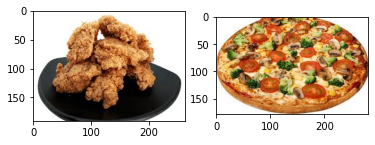

In [ ]:
# 사용 이미지

t2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/2.jpg",cv2.IMREAD_COLOR)
t2= cv2.cvtColor(t2, cv2.COLOR_BGR2RGB)
t4 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/4.jpg",cv2.IMREAD_COLOR)
t4= cv2.cvtColor(t4, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(t2)

plt.subplot(1, 2, 2)
plt.imshow(t4)

In [ ]:
type(t2)

numpy.ndarray

In [ ]:
# 모바일넷 모델

In [50]:
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(128,128,3))

model = Sequential()
model.add(base_model)



model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu',kernel_initializer="he_normal"))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(5, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

In [51]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

result = model.fit(idg_tr, epochs=50, validation_data= (X_test,y_test), batch_size= 16, callbacks=[earlystopping])

Epoch 1/50
103/103 [==============================] - 48s 439ms/step - loss: 3.1778 - accuracy: 0.2317 - val_loss: 1.3966 - val_accuracy: 0.5078
Epoch 2/50
103/103 [==============================] - 44s 429ms/step - loss: 1.7806 - accuracy: 0.2661 - val_loss: 1.3982 - val_accuracy: 0.5736
Epoch 3/50
103/103 [==============================] - 44s 427ms/step - loss: 1.6175 - accuracy: 0.2958 - val_loss: 1.3481 - val_accuracy: 0.6002
Epoch 4/50
103/103 [==============================] - 44s 428ms/step - loss: 1.5289 - accuracy: 0.3284 - val_loss: 1.2380 - val_accuracy: 0.6528
Epoch 5/50
103/103 [==============================] - 44s 429ms/step - loss: 1.4359 - accuracy: 0.3767 - val_loss: 1.1152 - val_accuracy: 0.6932
Epoch 6/50
103/103 [==============================] - 45s 431ms/step - loss: 1.3320 - accuracy: 0.4231 - val_loss: 0.9858 - val_accuracy: 0.7017
Epoch 7/50
103/103 [==============================] - 44s 428ms/step - loss: 1.2321 - accuracy: 0.4690 - val_loss: 0.8629 - val_ac

In [52]:
# evaluate
model.evaluate(X_test, y_test)

103/103 [==============================] - 1s 7ms/step - loss: 0.5362 - accuracy: 0.9232


[0.5362221002578735, 0.9232181310653687]

In [30]:
# evaluation=[0.3889729082584381, 0.9015617370605469] idg 사용 전

In [53]:
test_img1 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/1.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img1= cv2.resize(test_img1, dsize=(128,128)) # 사이즈 조절
test_img1 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred = model.predict(test_img1.reshape(-1, 128,128,3))
score=tf.nn.softmax(pred)

print("{:.2f}percnet confidence.".format( 100*np.max(score)))
print(score)

1/1 [==============================] - 0s 416ms/step
30.28percnet confidence.
tf.Tensor([[0.16560042 0.17714451 0.3028023  0.18807548 0.16637728]], shape=(1, 5), dtype=float32)


In [32]:
test_img2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/2.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img2= cv2.resize(test_img2, dsize=(128,128)) # 사이즈 조절
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred2 = model.predict(test_img2.reshape(-1, 128,128,3))
score2=tf.nn.softmax(pred2)

print("{:.2f}percnet confidence.".format( 100*np.max(score2)))
print(score2)

1/1 [==============================] - 0s 20ms/step
25.10percnet confidence.
tf.Tensor([[0.17738885 0.2510321  0.20841695 0.19298013 0.17018197]], shape=(1, 5), dtype=float32)


In [ ]:
# 34.03percnet confidence.
# 2nd tf.Tensor([[0.13059564 0.34217882 0.13138808 0.13371669 0.1315161  0.13060474]], shape=(1, 6), dtype=float32)

In [33]:
test_img3 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/3.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img3= cv2.resize(test_img3, dsize=(128,128)) # 사이즈 조절
test_img3 = cv2.cvtColor(test_img3, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred3 = model.predict(test_img3.reshape(-1, 128,128,3))
score3=tf.nn.softmax(pred3)

print("{:.2f}percnet confidence.".format( 100*np.max(score3)))
print(score3)

1/1 [==============================] - 0s 19ms/step
40.46percnet confidence.
tf.Tensor([[0.14885187 0.404587   0.14886002 0.14885053 0.1488506 ]], shape=(1, 5), dtype=float32)


In [ ]:
# 35.22percnet confidence.
# 2nd tf.Tensor([[0.13275458 0.3222036  0.14121322 0.13381198 0.13546191 0.13455471]]
# 3rd tf.Tensor([[0.13504496 0.1626961  0.13587035 0.13489316 0.29650405 0.1349914 ]]

In [47]:
test_img4 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/4.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img4= cv2.resize(test_img4, dsize=(128,128)) # 사이즈 조절
test_img4 = cv2.cvtColor(test_img4, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred4 = model.predict(test_img4.reshape(-1, 128,128,3))
score4=tf.nn.softmax(pred4)

print("{:.2f}percnet confidence.".format( 100*np.max(score4)))
print(score4)


1/1 [==============================] - 0s 22ms/step
29.22percnet confidence.
tf.Tensor([[0.17119914 0.2922199  0.18837704 0.18300442 0.16519949]], shape=(1, 5), dtype=float32)


In [ ]:
# 28.28percnet confidence
# 35.22percnet confidence.

In [ ]:
test_img5 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/5.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img5= cv2.resize(test_img5, dsize=(128,128)) # 사이즈 조절
test_img5 = cv2.cvtColor(test_img5, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred5 = model.predict(test_img5.reshape(-1, 128,128,3))
score5=tf.nn.softmax(pred5)

print("{:.2f}percnet confidence.".format( 100*np.max(score5)))
print(score5)

1/1 [==============================] - 0s 20ms/step
57.61percnet confidence.
tf.Tensor([[0.21194157 0.21194157 0.57611686]], shape=(1, 3), dtype=float32)


In [ ]:
test_img6 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/6.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img6= cv2.resize(test_img6, dsize=(256,256)) # 사이즈 조절
test_img6 = cv2.cvtColor(test_img6, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred6 = model.predict(test_img6.reshape(-1, 256,256,3))
score6=tf.nn.softmax(pred6)

print("{:.2f}percnet confidence.".format( 100*np.max(score6)))
print(score6)

1/1 [==============================] - 0s 21ms/step
57.61percnet confidence.
tf.Tensor(
[[0.21194708 0.5760907  0.21196224]
 [0.21194157 0.21194157 0.57611686]
 [0.21194157 0.21194157 0.57611686]
 [0.57611686 0.21194157 0.21194157]], shape=(4, 3), dtype=float32)


In [ ]:
#29.13percnet confidence.
#35.22percnet confidence.

In [ ]:
#위에서 본 햄버거
test_img7 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/03.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img7= cv2.resize(test_img7, dsize=(256,256)) # 사이즈 조절
test_img7 = cv2.cvtColor(test_img7, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred7 = model.predict(test_img7.reshape(-1, 256,256,3))
score7=tf.nn.softmax(pred7)

print("{:.2f}percnet confidence.".format( 100*np.max(score7)))
print(score7)

1/1 [==============================] - 0s 20ms/step
57.61percnet confidence.
tf.Tensor(
[[0.21194157 0.57611686 0.21194157]
 [0.21194157 0.21194157 0.57611686]
 [0.21194157 0.21194157 0.57611686]
 [0.21194157 0.57611686 0.21194157]], shape=(4, 3), dtype=float32)


In [54]:
#옆에서 본 햄버거
test_img8 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/46_xw9yoy5jribaygvjclfi.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img8= cv2.resize(test_img8, dsize=(256,256)) # 사이즈 조절
test_img8 = cv2.cvtColor(test_img8, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred8 = model.predict(test_img8.reshape(-1, 256,256,3))
score8=tf.nn.softmax(pred8)

print("{:.2f}percnet confidence.".format( 100*np.max(score8)))
print(score8)

1/1 [==============================] - 0s 415ms/step
37.10percnet confidence.
tf.Tensor([[0.15396823 0.16277806 0.3710476  0.15792796 0.15427817]], shape=(1, 5), dtype=float32)


In [55]:
#치킨 한조각
test_img9 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/0.jpg500050005000jpg5000.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img9= cv2.resize(test_img9, dsize=(256,256)) # 사이즈 조절
test_img9 = cv2.cvtColor(test_img9, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

pred9 = model.predict(test_img9.reshape(-1, 256,256,3))
score9=tf.nn.softmax(pred9)

print("{:.2f}percnet confidence.".format( 100*np.max(score9)))
print(score9)

1/1 [==============================] - 0s 22ms/step
37.00percnet confidence.
tf.Tensor([[0.15402797 0.1626407  0.37003848 0.15916125 0.15413165]], shape=(1, 5), dtype=float32)


In [61]:
#내가 찍은 돈까스
test_img10 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/KakaoTalk_20230117_154648765.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img10= cv2.resize(test_img10, dsize=(128,128)) # 사이즈 조절
test_img10 = cv2.cvtColor(test_img10, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

test_img10=test_img10 /255.0

pred10 = model.predict(test_img10.reshape(-1, 128,128,3))
score10=tf.nn.softmax(pred10)

print("{:.2f}percnet confidence.".format( 100*np.max(score10)))
print(score10)

1/1 [==============================] - 0s 19ms/step
40.13percnet confidence.
tf.Tensor([[0.14934255 0.15040326 0.40126547 0.14955641 0.1494322 ]], shape=(1, 5), dtype=float32)


In [ ]:
# tf.Tensor([[0.17226732 0.23989728 0.22468074 0.19596674 0.16718788]], shape=(1, 5), dtype=float32)

In [60]:
#교촌치킨
test_img11 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/KakaoTalk_20230117_154723479.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img11= cv2.resize(test_img11, dsize=(128,128)) # 사이즈 조절
test_img11 = cv2.cvtColor(test_img11, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

test_img11=test_img11 /255.0

pred11 = model.predict(test_img11.reshape(-1,128,128,3))
score11=tf.nn.softmax(pred11)

print("{:.2f}percnet confidence.".format( 100*np.max(score11)))
print(score11)

1/1 [==============================] - 0s 21ms/step
40.36percnet confidence.
tf.Tensor([[0.14899312 0.4035984  0.1494259  0.14898866 0.1489939 ]], shape=(1, 5), dtype=float32)


In [ ]:
# tf.Tensor([[0.17708781 0.20001115 0.1935521  0.2576018  0.17174716]], shape=(1, 5), dtype=float32)

Object ` fit` not found.


AttributeError: ignored